In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical

import numpy as np

import gym

In [2]:
# Policy
class Policy(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.001):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden = nn.ModuleList(
            [nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)]
        )
        self.fc2 = nn.Linear(hidden_dims[-1], output_dim)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, state):
        x = torch.tensor(state, dtype=torch.float32).to(self.device)
        x = F.relu(self.fc1(x))
        for hidden in self.hidden:
            x = F.relu(hidden(x))
        x = self.fc2(x)
        return x
    
    def select_action(self, state):
        with torch.no_grad():
            logits = self.forward(state)
            distribution = Categorical(logits=logits)
            action = distribution.sample()

            return action
        
    def full_pass(self, state):
        logits = self.forward(state)
        distribution = Categorical(logits=logits)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)
        return action, log_prob

In [3]:
# Value Function (only needed for VPG/Reinforce with baseline)
class Value(nn.Module):
    def __init__(self, input_dim, hidden_dims, lr=0.001):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden = nn.ModuleList(
            [nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)]
        )
        self.fc2 = nn.Linear(hidden_dims[-1], 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = torch.tensor(state, dtype=torch.float32).to(self.device)
        x = F.relu(self.fc1(x))
        for hidden in self.hidden:
            x = F.relu(hidden(x))
        x = self.fc2(x)
        return x

In [4]:
# Agent
class ReinforceAgent():
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.001, gamma=0.99):
        self.policy_model = Policy(input_dim, hidden_dims, output_dim, lr)
        self.value_model = Value(input_dim, hidden_dims, lr)
        self.gamma = gamma
        self.reset()
        
    def reset(self):
        self.log_probs = []
        self.values = []
    
    def optimize(self, rewards):
        trajectory_len = len(rewards)
        gammas = np.array([self.gamma**i for i in range(trajectory_len)])
        returns = np.array([np.sum(rewards[t:] * gammas[:trajectory_len-t]) for t in range(trajectory_len)])
        returns = torch.tensor(returns, dtype=torch.float32).to(self.policy_model.device)
        values = torch.vstack(self.values).squeeze(1)
        advantages = returns - values
        
        self.log_probs = torch.vstack(self.log_probs).squeeze(1)
        
        loss = -(advantages.detach() * self.log_probs).mean()
        
        self.policy_model.optimizer.zero_grad()
        loss.backward()
        self.policy_model.optimizer.step()
        
        value_loss = advantages.pow(2).mean()
        self.value_model.optimizer.zero_grad()
        value_loss.backward()
        self.value_model.optimizer.step()
        
        self.reset()
    
    def interract(self, state):
        action, log_prob = self.policy_model.full_pass(state)
        value = self.value_model(state)
        self.log_probs.append(log_prob)
        self.values.append(value)
        return action.cpu().item()

In [5]:
# main loop
env = gym.make('LunarLander-v2')
episodes = 3000

observation_dims = env.observation_space.shape[0]
actions_dims = env.action_space.n
hidden_dims = (128, 64)
lr = 0.0005
gamma = 0.99

In [6]:
agent = ReinforceAgent(observation_dims, hidden_dims, actions_dims, lr=lr, gamma=gamma)

rewards_history = []
for episode in range(episodes):
    obs, done = env.reset(), False
    rewards = []
    reward_sum = 0
    while not done:
        action = agent.interract(obs)
        next_obs, reward, done, _ = env.step(action)
        rewards.append(reward)
        reward_sum += reward
        obs = next_obs
    agent.optimize(rewards)
    rewards_history.append(reward_sum)
    
    if episode > 100:
        mean = np.mean(rewards_history[-100:])
        print(f'Episode: {episode}, Mean of rewards: {mean}', end='\r')
        if mean >= 200:
            break

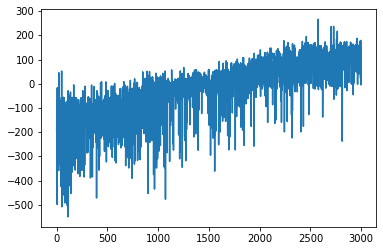

In [7]:
import matplotlib.pyplot as plt

plt.plot(rewards_history)